<div style="text-align: right"> CS824 - Lab 7b (2022) </div>

### Lab 7b - Using PCA and t-SNE (MNIST with style!)

In this lab we will further explore two of the most widely used Dimensionality Reduction techniques, namely Principal Components Analyses (PCA) and t-Distributed Stochastic Neighbor Embedding (t-SNE). 

We will:

 - Look at some additional **PCA** elemetns within Python.
 - Implement **t-SNE** in Python.
 - Visualise the outputs of the two algorithms and consider the differences between them.


## The Fashion-MNIST data set

We will look at this open source dataset and try to visualize some results using both the output of PCA and t-SNE algorithms applied to it.

The data set we are using is the Fashion-MNIST dataset and can be found here https://github.com/zalandoresearch/fashion-mnist. You may have read articles or worked on tutorials using the 'original' MNIST data set that contained example images of hand-written digits (0-9). The Fashion-MNIST dataset once again uses grayscale images (in this case 28x28 pixels), but now each contains a sample image of a fashion product taken from one of 10 categories - there are 7,000 images per category giving 70,000 images in total. The training set has 60,000 images, and the test set has 10,000 images.

Each example is assigned to one of the following ten labels:

- 0 T-shirt/top
- 1 Trouser
- 2 Pullover
- 3 Dress
- 4 Coat
- 5 Sandal
- 6 Shirt
- 7 Sneaker
- 8 Bag
- 9 Ankle boot

You can find a nice graphic showing some typical images in the set at the link below -

https://github.com/zalandoresearch/fashion-mnist/blob/master/doc/img/fashion-mnist-sprite.png


### Loading the Fashion-MNIST dataset

The function below to load up the dataset is provided in the `utils` folder in Github, but is reproduced here for ease of use.


In [1]:
# Fashion MNIST reader

def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path` (which you will need to pass as a parameter)"""
    
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

And you will also need the various 'base' libraries

In [2]:
# Load the 'basic' libraries... We also set a common random seed to ensure we get the same outputs later

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

rand_seed = 17

### Copy the data sets

I took the 4 data files from the \data\fashion folder on Github and put them into a local folder that I have access to at `..Lab_7\fashion`, so you need to choose a location that will work for you. I then used the `load_mnist` function (defined above) to fetch these data.


In [3]:
# X_train, y_train = load_mnist('fashion', kind='train')

X_train, y_train = load_mnist('C:/Users/Nikit/Documents/UniWork/labwork/nikit_QMwithAI_labWork/datasets/fashion', kind='train')
    

### Check the training data was loaded

The `X` matrix should contain 60,000 rows (images) by 784 'features' (one for the value of each pixel in the 28x28 pixel display.

The `y` vector should 60,000 rows with a single (`target`) value of 0 - 9.


In [4]:
X_train.shape

(60000, 784)

In [5]:
y_train.shape

(60000,)

In [6]:
X_train2 = X_train.reshape((60000,28,28))


In [7]:
X_train2.shape

(60000, 28, 28)

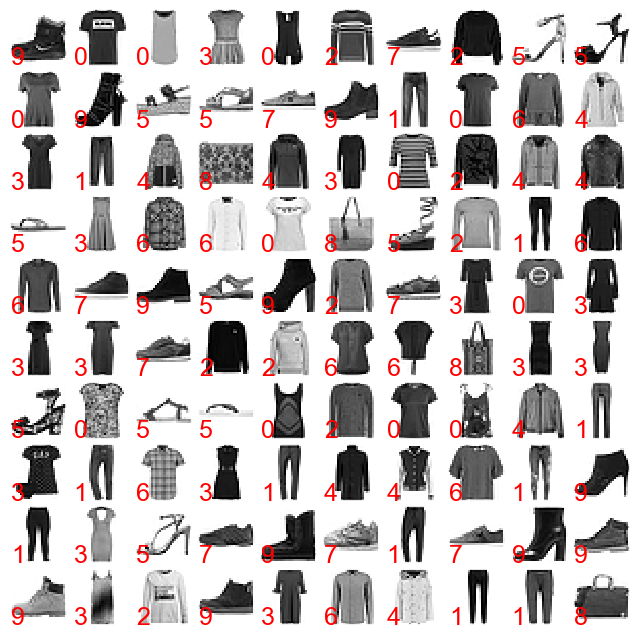

In [8]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(X_train2[i], cmap='binary', interpolation='nearest')
    ax.text(0.02, 0.02, str(y_train[i]),
            transform=ax.transAxes, color='red')


### Exercise 7b.1 - Visualise some of these data  (SUBMIT)

Check the number of examples in each of the 10 output (`target`) classes to confirm that there are 6,000 in each of the different cateogories of fashion items.

In [9]:
# Initializing an empty dictionary to append the class as keys and the number
# of samples as values
# This is to confirm that the classes from 0-9 are having 6000 samples each
target_dict = {}

# running a for loop for the class iteration
for i in range(10):
    count = (y_train == i).sum()
    target_dict.update({i: count})

print(target_dict)

{0: 6000, 1: 6000, 2: 6000, 3: 6000, 4: 6000, 5: 6000, 6: 6000, 7: 6000, 8: 6000, 9: 6000}


Write a little function to show an item from the training set - i.e. you pass a value `N` to this function and it shows the image associated with the `N'th` image.

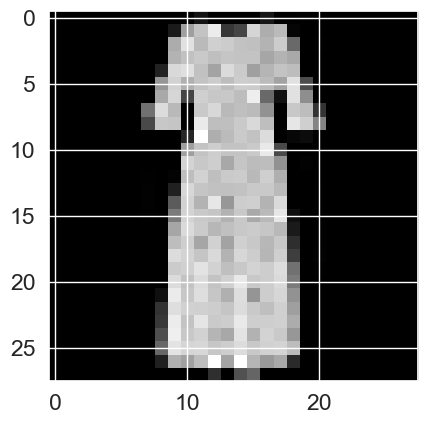

In [10]:
'''
This function takes 'value' as an inputm which is a integer value
representing the data in the np array, which is in the X_train
fasion_mnist dataset

Arguments
---------
base_rate  : int, representing the index of the numpy array
             which in our case is the image associated with this
             is the X_train

Returns
-------
the plotted image of the N'th index number
'''
def show_image(value):
    image = X_train2[value]

    fig = plt.figure
    plt.imshow(image, cmap='gray')
    plt.show()

show_image(6999)

### Select a sub-set of the training set

If we attempted to run some of the algorithms below on all 60,000 examples this would take quite a bit of time - particularly for t-SNE. As such we will take just the first 5,000 samples for our initial experiments.


In [11]:
# Take just the first 5,000 examples from the training dataset

X_subset = X_train[0:5000]
y_subset = y_train[0:5000]


### Exercise 7b.2 - Check the sub-set  (SUBMIT)

Check that there are roughly 500 examples of each fashion category on this newly created sub-set.


In [12]:
# Initializing an empty dictionary to append the class as keys and the number
# of samples as values
# This is to confirm that the classes from 0-9 are having approximately 500 samples each
target_dict_sub = {}

# running a for loop for the class iteration
for i in range(10):
    count = (y_subset == i).sum()
    target_dict_sub.update({i: count})

print(target_dict_sub)

{0: 457, 1: 556, 2: 504, 3: 501, 4: 488, 5: 493, 6: 493, 7: 512, 8: 490, 9: 506}


### Run a PCA

We will run a PCA on this sub-set, indicating that we wish to keep input from just the first 6 principle components. This is only one of a number of parameters that we could set, but we will leave the rest at default values.


In [13]:
from sklearn.decomposition import PCA

time_start = time.time()

pca = PCA(n_components=6)
pca_result = pca.fit_transform(X_subset)

print('PCA completed...  Time elapsed: {} seconds'.format(time.time()-time_start))

PCA completed...  Time elapsed: 0.07136273384094238 seconds


### Looking at the values of the first 6 PCs

We can save the six principal components to a new data-frame `df_pca` and investigate the amount of variance in the overall data that is explained by each of these six components.

In [14]:
df_pca = pd.DataFrame(columns = ['pc1','pc2','pc3','pc4','pc5','pc6'])

df_pca['pc1'] = pca_result[:,0]
df_pca['pc2'] = pca_result[:,1]
df_pca['pc3'] = pca_result[:,2]
df_pca['pc4'] = pca_result[:,3]
df_pca['pc5'] = pca_result[:,4]
df_pca['pc6'] = pca_result[:,5]

print ('Variance explained per principal component: {}'.format(pca.explained_variance_ratio_))

Variance explained per principal component: [0.28728633 0.18198231 0.05932144 0.0500178  0.04035759 0.03349527]


### It might be interesting to view the data set just using these first two PCs

We can see that the first 2 principal components explain just under 50% on the variation in the `X_subset`, so it might be interestsing to see how the output labels (in `y_subset`) are situated based on these two dimenstions.

To do this we need to create a scatter plot of the relevant points. (The function we create `fashion_viz` will also be able to be used for the output from the t-SNE algorithm later.)


### Function to visualise outputs from *Dim Red* algorithms - `fashion_viz()`

This function takes two arguments: (1) `x` a 2-dimensional array that contains the output of the algorithm (which is essentially a list of each example and its predicted target class), and (2) `colours` a 1-dimensional array containing the colours to be used for different labels in the dataset.

**added** (3) 'title' to add the title to explain visualisation

The function will create a scatter plot with as many unique colours as there are categories in the dataset. 


In [15]:
# Utility function to visualize the outputs of PCA or t-SNE
 
def fashion_viz(x, colors, title=None):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(int)])
    plt.title(title)
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return
#    return f, ax, sc, txts


### Now we can visualise the data using the first two PCs

We created variables (above) for the first two PCs and we have the categories in the `y_subset` array.


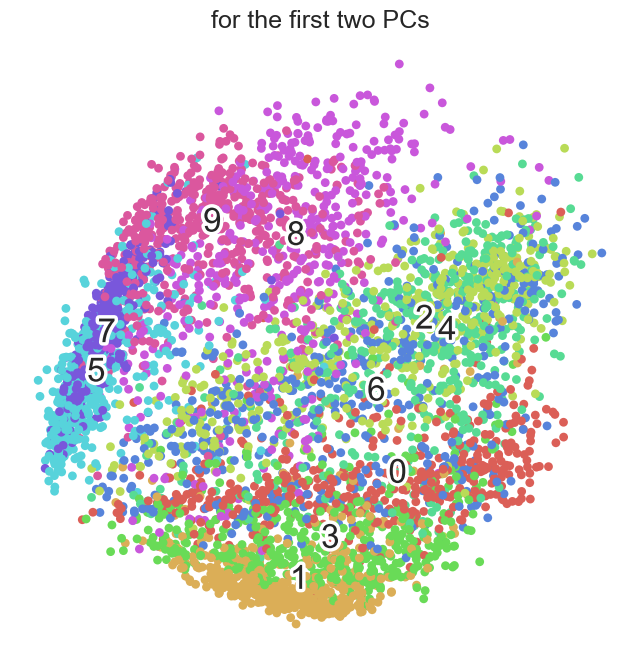

In [16]:
top_two_comp = df_pca[['pc1','pc2']]        # Create a variable with the first and second PCs

fashion_viz(top_two_comp.values,y_subset, title='for the first two PCs')   # Visualise the PCA output in PC1 and PC2 space



Well, this is not a perfect separation by any means but some clustering is clearly visible...  and the fact that we are representing these 784 dimensional images using just 2 (!) dimensions is quite impressive. 

We can see that `trousers` [1] seem fairly distinct, while `sandals` [5] and `sneakers` [7] form a cluster that begins to bleed into `ankle boots` [9]. The group formed by `pullovers` [2], `coats` [4] and `shirts` [6] is, perhaps not surprisingly, the least well separated.


### Exercise 7b.3 - What if we had no principle compnents?  (SUBMIT)

Try seeing what the output might look like if you just selected two of the initial 784 dimensions and plotted the location of the examples and their different target values based on these two random dimensions. Be careful, if you choose random values near the 'start' or 'end' of the image these may be largely empty and so all your data/target labels will 'collapse' into the corner of the graph.


In [17]:
dim1 = np.random.randint(0, 784)
dim2 = np.random.randint(0, 784)
rand_dim_1 = X_subset[:, dim1]
rand_dim_2 = X_subset[:, dim2]
selected_two_dim = np.array([rand_dim_1, rand_dim_2]).T
selected_two_dim.shape

(5000, 2)

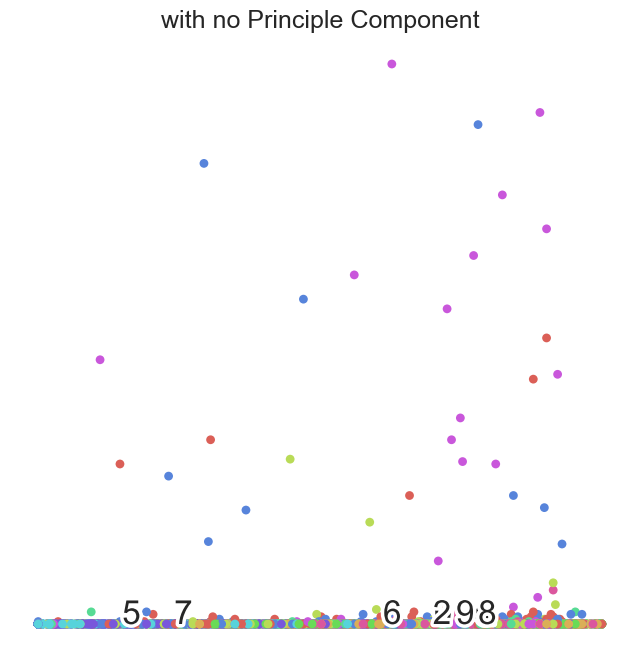

In [18]:
fashion_viz(selected_two_dim, y_subset, title='with no Principle Component')

### Try using t-SNE

We can now do a similar thing but using the t-SNE algorithm. This is available in Sciket-learn and has quite a lot of parameters that can be tuned. We will leave the 'default' values at present, except for `n_iter` which we will reduce to 500 (from the default of 1,000) to try to save a little processing time. (Though you may still find that it takes a minute or so to produce the results - so be patient!)

This is also a stochastic process, so we will use the random seed we created above to ensure comparable results.


In [19]:
from sklearn.manifold import TSNE
import time
time_start = time.time()

fashion_tsne = TSNE(random_state=rand_seed, n_iter=500).fit_transform(X_subset)

print ('t-SNE completed...  Time elapsed: {} seconds'.format(time.time()-time_start))

c:\Users\Nikit\anaconda3\envs\myenv\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Nikit\anaconda3\envs\myenv\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE completed...  Time elapsed: 6.015057325363159 seconds


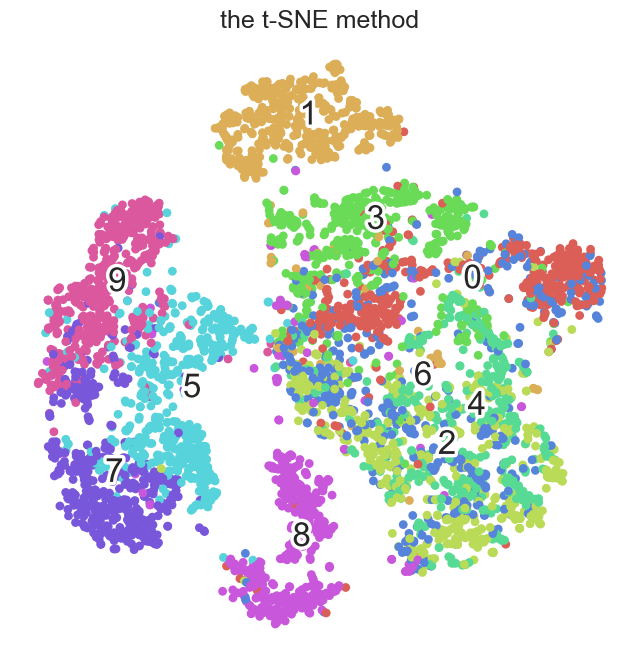

In [20]:
fashion_viz(fashion_tsne, y_subset, title='the t-SNE method')


It seems that the t-SNE (again using just 2 dimensions) does an even better job of clustering fashion images into distinct categories. Once again we see that `trousers` [1] are fairly distinct, as are `bags` [8]. There also appears to be a decent separation with the similar items of `sandals` [5], `sneakers` [7] and `ankle boots` [9]. However, once again the group formed by `pullovers` [2], `coats` [4] and `shirts` [6] shows quite a bit of overlap, and `t-shirts` [0] is interspersed betwen that group and `dresses` [3].


### Transform the data before passing it to t-SNE

In the Scikit-learn documentation relating to t-SNE we find the following note:

 - "It is highly recommended to use another dimensionality reduction method (e.g., PCA for dense data or TruncatedSVD for sparse data) to reduce the number of dimensions to a reasonable amount (e.g., 50) if the number of features is very high. This will suppress some noise and speed up the computation of pairwise distances between samples."
 
So we could try to reduce the number of initial dimensions by first applying PCA and then passing the reduced set of dimensions to the t-SNE algorithm.

Given how fast the PCA algorithm is we should also now be able to use a larger sub-set of sample images (let's try 15,000) from which we will take just the first 35 principle components.


In [21]:
# Let's take a much larger sub-set of 15,000 examples from the training dataset

X_subset2 = X_train[0:15000]
y_subset2 = y_train[0:15000]


In [22]:
# Let's try PCA on this larger sub-set and get the first 35 PCs

time_start = time.time()

pca_35 = PCA(n_components=35)
pca_result_35 = pca_35.fit_transform(X_subset2)

print ('PCA with 35 components completed... Time elapsed: {} seconds'.format(time.time()-time_start))
print ('Cumulative variance explained by 35 principal components: {}'.format(np.sum(pca_35.explained_variance_ratio_)))

PCA with 35 components completed... Time elapsed: 0.3140294551849365 seconds
Cumulative variance explained by 35 principal components: 0.8349022486132446


In [23]:
# Let's try PCA on the smaller sub-set (5000 examples) and get the first 35 PCs

time_start = time.time()

small_pca_35 = PCA(n_components=35)
small_pca_result_35 = small_pca_35.fit_transform(X_subset)

print ('PCA with 35 components completed... Time elapsed: {} seconds'.format(time.time()-time_start))
print ('Cumulative variance explained by 35 principal components: {}'.format(np.sum(small_pca_35.explained_variance_ratio_)))

PCA with 35 components completed... Time elapsed: 0.1232461929321289 seconds
Cumulative variance explained by 35 principal components: 0.8372671367667336


### Seems effective

As expected the PCA was pretty fast (under a second) and  gives us the data in a reduced set of 35 dimensions (as opposed to the 784 we started with), which appears to account for just over 83% of the variation in the data set.

Passing this reduced data set to the t-SNE algorithm should now run more rapidly (hopefully!)

Strictly we should probably test this reduced (35D) data set using our initial 5,000 data points to see what effect the reduction in dimensions has had...  then we can see whether we can efficiently work with more data points.

Indeed - having seen how long the algorithm takes with 15,000 data points I would suggest you revert back to the smaller 5,000 data set for the completion of this exercise. 


In [24]:
# Pass the 5000 example dataset (based on first 35 PCs) to the t-SNE algorithm

time_start = time.time()

fashion_pca_tsne_small = TSNE(random_state=rand_seed, n_iter=500).fit_transform(small_pca_result_35)

print ('t-SNE completed...  Time elapsed: {} seconds'.format(time.time()-time_start))

c:\Users\Nikit\anaconda3\envs\myenv\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Nikit\anaconda3\envs\myenv\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE completed...  Time elapsed: 5.628935813903809 seconds


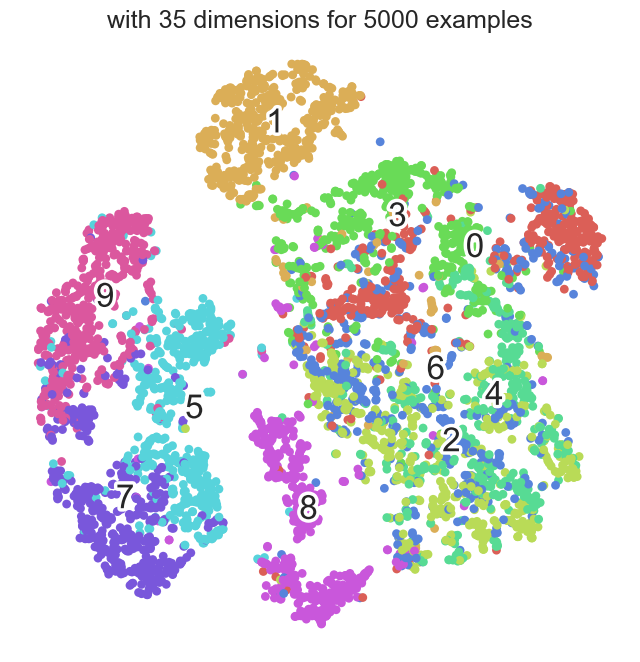

In [25]:
fashion_viz(fashion_pca_tsne_small, y_subset, title='with 35 dimensions for 5000 examples')

In [26]:
# Pass the reduced dataset (based on first 35 PCs) to the t-SNE algorithm

time_start = time.time()

fashion_pca_tsne = TSNE(random_state=rand_seed, n_iter=500).fit_transform(pca_result_35)

print ('t-SNE completed...  Time elapsed: {} seconds'.format(time.time()-time_start))


c:\Users\Nikit\anaconda3\envs\myenv\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Nikit\anaconda3\envs\myenv\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE completed...  Time elapsed: 24.8072350025177 seconds


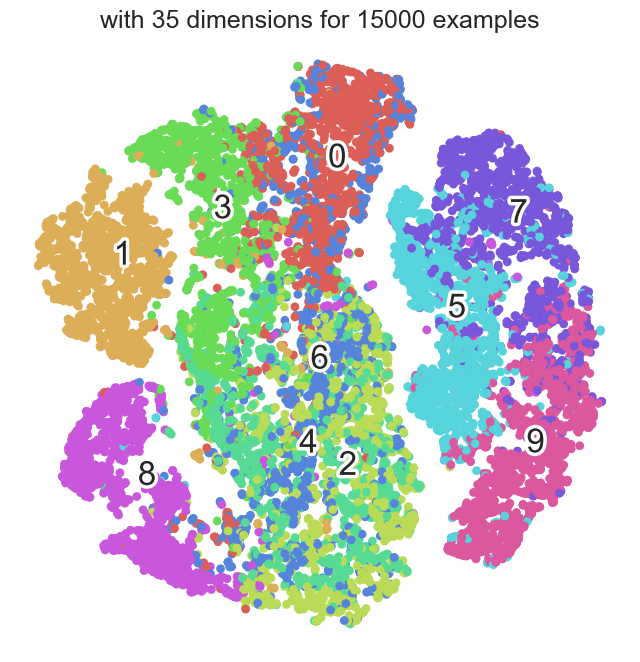

In [27]:
fashion_viz(fashion_pca_tsne, y_subset2,title='with 35 dimensions for 15000 examples')

### Exercise 7b.4 - Compare with all 784 dimensions  (SUBMIT)

How does this visualisation compare to the one you started with (above)?

You may need to think about a sensible number of data points to select, depending on efficiency.

How do 35 dimensions compare to all 784, and is this surprising?

==> The visualisation with 784 dimensions compared to the 35 dim t-SNE is almost the
    same for the 5000 example and the 15000 example datasets
    The cumulative variance appears to be 100% in the dataset


In [28]:
# Let's try PCA on this 5000 example sub-set and with all the 784 dim

time_start = time.time()

pca_784_small = PCA(n_components=784)
pca_result_784_small = pca_784_small.fit_transform(X_subset)

print ('PCA with 784 components completed... Time elapsed: {} seconds'.format(time.time()-time_start))
print ('Cumulative variance explained by 784 principal components: {}'.format(np.sum(pca_784_small.explained_variance_ratio_)))

PCA with 784 components completed... Time elapsed: 0.5004675388336182 seconds
Cumulative variance explained by 784 principal components: 1.0000000000000002


In [29]:
# Let's try PCA on this larger sub-set and with all the 784 dim

time_start = time.time()

pca_784 = PCA(n_components=784)
pca_result_784 = pca_784.fit_transform(X_subset2)

print ('PCA with 784 components completed... Time elapsed: {} seconds'.format(time.time()-time_start))
print ('Cumulative variance explained by 784 principal components: {}'.format(np.sum(pca_784.explained_variance_ratio_)))

PCA with 784 components completed... Time elapsed: 0.95265793800354 seconds
Cumulative variance explained by 784 principal components: 1.0000000000000002


In [30]:
# Pass the 5000 example dataset (with all the 784 PCs) to the t-SNE algorithm

time_start = time.time()

fashion_pca_tsne_784_small = TSNE(random_state=rand_seed, n_iter=500).fit_transform(pca_result_784_small)

print ('t-SNE completed...  Time elapsed: {} seconds'.format(time.time()-time_start))

c:\Users\Nikit\anaconda3\envs\myenv\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Nikit\anaconda3\envs\myenv\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE completed...  Time elapsed: 7.963698863983154 seconds


In [31]:
# Pass the larger dataset (with all the 784 PCs) to the t-SNE algorithm

time_start = time.time()

fashion_pca_tsne_784 = TSNE(random_state=rand_seed, n_iter=500).fit_transform(pca_result_784)

print ('t-SNE completed...  Time elapsed: {} seconds'.format(time.time()-time_start))

c:\Users\Nikit\anaconda3\envs\myenv\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Nikit\anaconda3\envs\myenv\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE completed...  Time elapsed: 28.580094814300537 seconds


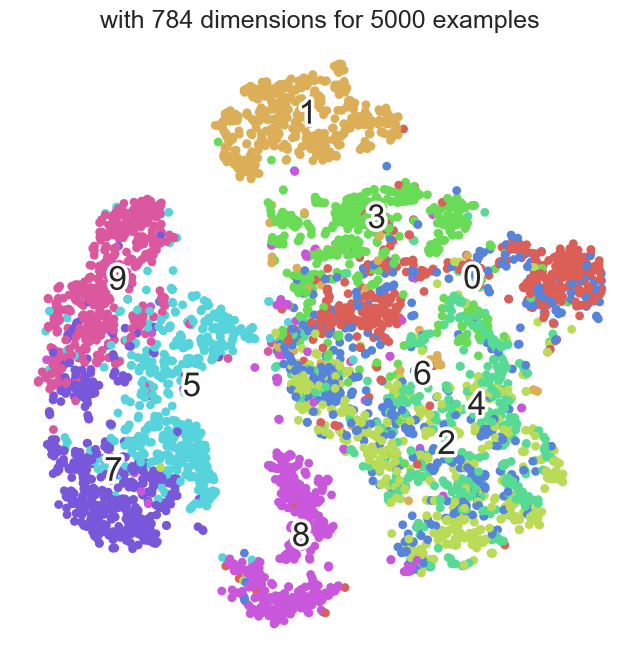

In [32]:
fashion_viz(fashion_pca_tsne_784_small, y_subset, title="with 784 dimensions for 5000 examples")

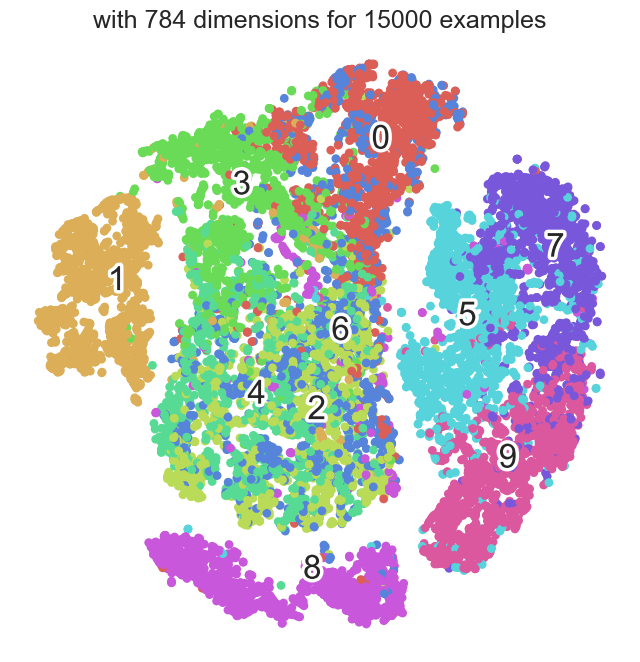

In [33]:
fashion_viz(fashion_pca_tsne_784, y_subset2, title="with 784 dimensions for 15000 examples")

In [34]:
X_subset3 = X_train[45000:55000]
y_subset3 = y_train[45000:55000]

In [35]:
# Let's try PCA on this 10000 example but at different location from the main dataset 
# with all the 784 dim

time_start = time.time()

pca_784_diff = PCA(n_components=784)
pca_result_784_diff = pca_784_diff.fit_transform(X_subset3)

print ('PCA with 784 components completed... Time elapsed: {} seconds'.format(time.time()-time_start))
print ('Cumulative variance explained by 784 principal components: {}'.format(np.sum(pca_784_diff.explained_variance_ratio_)))

PCA with 784 components completed... Time elapsed: 0.6948232650756836 seconds
Cumulative variance explained by 784 principal components: 1.0


In [36]:
# Pass the 10000 example dataset (with all the 784 PCs) to the t-SNE algorithm

time_start = time.time()

fashion_pca_tsne_784_diff = TSNE(random_state=rand_seed, n_iter=500).fit_transform(pca_result_784_diff)

print ('t-SNE completed...  Time elapsed: {} seconds'.format(time.time()-time_start))

c:\Users\Nikit\anaconda3\envs\myenv\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Nikit\anaconda3\envs\myenv\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE completed...  Time elapsed: 18.146297216415405 seconds


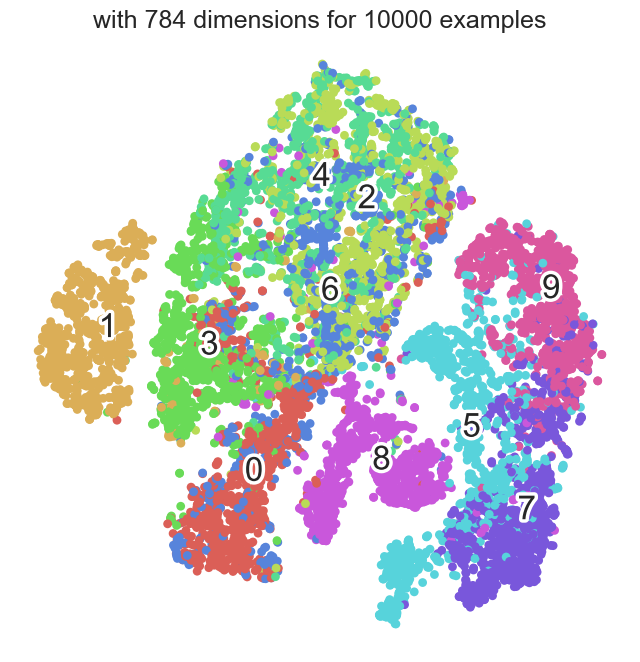

In [37]:
fashion_viz(fashion_pca_tsne_784_diff, y_subset3, title="with 784 dimensions for 10000 examples")

### Exercise 7b.5 - Try some alternatives  (SUBMIT)

Use a few different sets of PCs - e.g. down to just the first 5 to 10 - and see what impact this makes on effective visualisation. The fewer dimensions (PCs) you include and pass to the t-SNE algorithm, the faster that should operate and so the larger the sample set you can experiment with.

Provide some comment on the results of your experiments.


In [38]:
# Let's try PCA on this larger sub-set and with all the 784 dim

time_start = time.time()

pca_10 = PCA(n_components=10)
pca_result_10 = pca_10.fit_transform(X_subset2)

print ('PCA with 10 components completed... Time elapsed: {} seconds'.format(time.time()-time_start))
print ('Cumulative variance explained by 10 principal components: {}'.format(np.sum(pca_10.explained_variance_ratio_)))

PCA with 10 components completed... Time elapsed: 0.23225045204162598 seconds
Cumulative variance explained by 10 principal components: 0.7208475054706702


In [39]:
# Pass the larger dataset (with all the 784 PCs) to the t-SNE algorithm

time_start = time.time()

fashion_pca_tsne_10 = TSNE(random_state=rand_seed, n_iter=500).fit_transform(pca_result_10)

print ('t-SNE completed...  Time elapsed: {} seconds'.format(time.time()-time_start))

c:\Users\Nikit\anaconda3\envs\myenv\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Nikit\anaconda3\envs\myenv\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE completed...  Time elapsed: 25.9288547039032 seconds


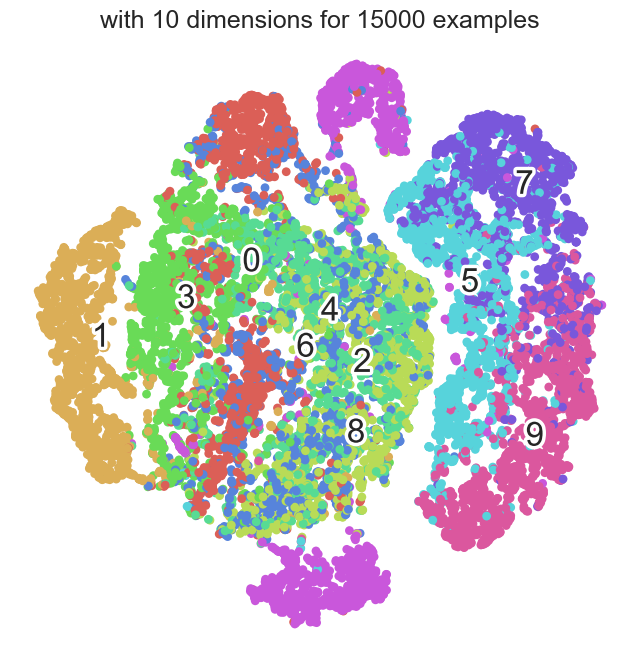

In [40]:
fashion_viz(fashion_pca_tsne_10, y_subset2, title="with 10 dimensions for 15000 examples")